# Predicting DFT Energies with GNNs

QM9 is a dataset of 134,000 molecules consisting of 9 heavy atoms drawn from the elements C, H, O, N, F{cite}`ramakrishnan2014quantum`. The features are the xyz coordinates ($\mathbf{X}$) and elements ($\vec{e}$) of the molecule. The coordinates are determined from B3LYP/6-31G(2df,p) level DFT geometry optimization. There are multiple labels (see table below), but we'll be interested specifically in the energy of formation (Enthalpy at 298.15 K). The goal in this chapter is to regress a graph neural network to predict the energy of formation given the coordinates of a molecule. We will build upon ideas in the following chapters:

1. {doc}`../ml/regression`
2. {doc}`../dl/gnn`
3. {doc}`../dl/data`


QM9 is one of the most popular dataset for machine learning and deep learning since it came out in 2014. The first papers could achieve about 10 kcal/mol on this regression problem and now are down to ~1 kcal/mol and lower. Any model on this dataset must be translation, rotation, and permutation invariant. 

## Label Description

|Index | Name | Units | Description|
 |:-----|-------|-------|-----------:|
  |0  |index  |   -            |Consecutive, 1-based integer identifier of molecule|
  |1  |A      |   GHz          |Rotational constant A|
  |2  |B      |   GHz          |Rotational constant B|
  |3  |C      |   GHz          |Rotational constant C|
  |4  |mu     |   Debye        |Dipole moment|
  |5  |alpha  |   Bohr^3       |Isotropic polarizability|
  |6  |homo   |   Hartree      |Energy of Highest occupied molecular orbital (HOMO)|
  |7  |lumo   |   Hartree      |Energy of Lowest unoccupied molecular orbital (LUMO)|
 |8 | gap   |    Hartree     | Gap, difference between LUMO and HOMO|
 |9 | r2    |    Bohr^2      | Electronic spatial extent|
 |10 | zpve  |    Hartree     | Zero point vibrational energy|
 |11 | U0    |    Hartree     | Internal energy at 0 K|
 |12 | U     |    Hartree     | Internal energy at 298.15 K|
 |13 | H     |    Hartree     | Enthalpy at 298.15 K|
 |14 | G     |    Hartree     | Free energy at 298.15 K|
 |15 | Cv    |    cal/(mol K) | Heat capacity at 298.15 K|


## Data

I have written some helper code in the `fetch_data.py` file. It downloads the data and converts into a format easily used in Python. The data returned from this function is broken into the features $\mathbf{X}$ and $\vec{e}$. $\mathbf{X}$ is an $N\times4$ matrix of atom positions + partial charge of the atom. $\vec{e}$ is vector of atomic numbers for each atom in the molecule. Remember to slice the specific label you want from the label vector.

## Running This Notebook


Click the &nbsp;<i aria-label="Launch interactive content" class="fas fa-rocket"></i>&nbsp; above to launch this page as an interactive Google Colab. See details below on installing packages.

````{tip} My title
:class: dropdown
To install packages, execute this code in a new cell. 

```
!pip install dmol-book
```

If you find install problems, you can get the latest working versions of packages used in [this book here](https://github.com/whitead/dmol-book/blob/main/package/setup.py)

````

In [6]:
import tensorflow as tf
import numpy as np
from fetch_data import qm9_parse, qm9_fetch
import dmol


Let's load the data. This step will take a few minutes as it is downloaded and processed. 

In [7]:
qm9_records = qm9_fetch()

data = qm9_parse(qm9_records)


Found existing record file, delete if you want to re-fetch


`data` is an iterable containing the data for the 133k molecules. Let's examine the first one.

In [8]:
for d in data:
    print(d)
    break


((<tf.Tensor: shape=(5,), dtype=int64, numpy=array([6, 1, 1, 1, 1])>, <tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[-1.2698136e-02,  1.0858041e+00,  8.0009960e-03, -5.3568900e-01],
       [ 2.1504159e-03, -6.0313176e-03,  1.9761203e-03,  1.3392100e-01],
       [ 1.0117308e+00,  1.4637512e+00,  2.7657481e-04,  1.3392200e-01],
       [-5.4081506e-01,  1.4475266e+00, -8.7664372e-01,  1.3392299e-01],
       [-5.2381361e-01,  1.4379326e+00,  9.0639728e-01,  1.3392299e-01]],
      dtype=float32)>), <tf.Tensor: shape=(16,), dtype=float32, numpy=
array([ 1.0000000e+00,  1.5771181e+02,  1.5770998e+02,  1.5770699e+02,
        0.0000000e+00,  1.3210000e+01, -3.8769999e-01,  1.1710000e-01,
        5.0480002e-01,  3.5364101e+01,  4.4748999e-02, -4.0478931e+01,
       -4.0476063e+01, -4.0475117e+01, -4.0498596e+01,  6.4689999e+00],
      dtype=float32)>)


These are Tensorflow Tensors. They can be converted to numpy arrays via `x.numpy()`. The first item is the element vector `6,1,1,1,1`. Do you recognize the elements? It's C, H, H, H, H. The positions come next. Note that there is an extra column containing the atom partial charges, which we will not use as a feature. Finally, the last tensor is the label vector. 

Now we will do some processing of the data to get into a more usable format. Let's convert to numpy arrays, remove the partial charges, and convert the elements into one-hot vectors.

In [9]:
def convert_record(d):
    # break up record
    (e, x), y = d
    #
    e = e.numpy()
    x = x.numpy()
    r = x[:, :3]
    # make ohc size larger
    # so use same node feature
    # shape later
    ohc = np.zeros((len(e), 16))
    ohc[np.arange(len(e)), e - 1] = 1
    return (ohc, r), y.numpy()[13] # This can be changed to any other variable. Number 6 is homo and number 13 is enthalpy.


for d in data:
    (e, x), y = convert_record(d)
    print("Element one hots\n", e)
    print("Coordinates\n", x)
    print("Label:", y)
    break


Element one hots
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Coordinates
 [[-1.2698136e-02  1.0858041e+00  8.0009960e-03]
 [ 2.1504159e-03 -6.0313176e-03  1.9761203e-03]
 [ 1.0117308e+00  1.4637512e+00  2.7657481e-04]
 [-5.4081506e-01  1.4475266e+00 -8.7664372e-01]
 [-5.2381361e-01  1.4379326e+00  9.0639728e-01]]
Label: -40.475117


# Explanation of the data

We predict HOMO energy because it is computationally demanding:
https://chainer-chemistry.readthedocs.io/en/latest/tutorial.html#homo-prediction-by-nfp

X is Nx4 matrix of atom positions + partial charge of atoms
e is vector of atomic numbers for each atom in molecules

after drop of partial charge we define “r” which is only the coordinates (x,y,z)

y vector contains all features in this project we choose feature 6 which is the HOMO energy.


## Baseline Model

Before we get too far into modeling, let's see what a simple model can do for accuracy. This will help establish a baseline model which any more sophisticated implementation should exceed in accuracy. You can make many choices for this, but I'll just make a linear regression based on number of atom types.

In [10]:
import jax.numpy as jnp
import jax.example_libraries.optimizers as optimizers
import jax
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


@jax.jit
def baseline_model(nodes, w, b):
    # get sum of each element type
    atom_count = jnp.sum(nodes, axis=0)
    yhat = atom_count @ w + b
    return yhat


def baseline_loss(nodes, y, w, b):
    return (baseline_model(nodes, w, b) - y) ** 2


baseline_loss_grad = jax.grad(baseline_loss, (2, 3))
w = np.ones(16)
b = 0.0


We've set-up our simple regression model. One complexity is that we cannot batch the molecules like normal because each molecule contains different shaped tensors.

In [15]:
# we'll just train on 5,000 and use 1,000 for test
# shuffle, but only once (reshuffle_each_iteration=False) so
# we lock in which are train/test/val

shuffled_data = data.shuffle(7000, reshuffle_each_iteration=False)
test_set = shuffled_data.take(1000)
valid_set = shuffled_data.skip(1000).take(1000)
train_set = shuffled_data.skip(2000).take(5000)


# shuffled_data = data.shuffle(70, reshuffle_each_iteration=False)
# test_set = shuffled_data.take(10)
# valid_set = shuffled_data.skip(10).take(10)
# train_set = shuffled_data.skip(20).take(50)


The labels in this data are quite large, so we're going to make a transform on them to make our learning rates and training going more smoothly. 

In [16]:
ys = [convert_record(d)[1] for d in train_set]
train_ym = np.mean(ys)
train_ys = np.std(ys)
print("Mean = ", train_ym, "Std =", train_ys)


Mean =  -361.58588 Std = 43.364204


Now we'll just use this transform when training: $y_s = \frac{y - \mu_y}{\sigma_y}$ and then our predictions will be transformed by $\hat{y} = \hat{f}(e,x) \cdot \sigma_y + \mu_y$. This just helps standardize our range of outputs.

In [17]:
def transform_label(y):
    return (y - train_ym) / train_ys


def transform_prediction(y):
    return y * train_ys + train_ym


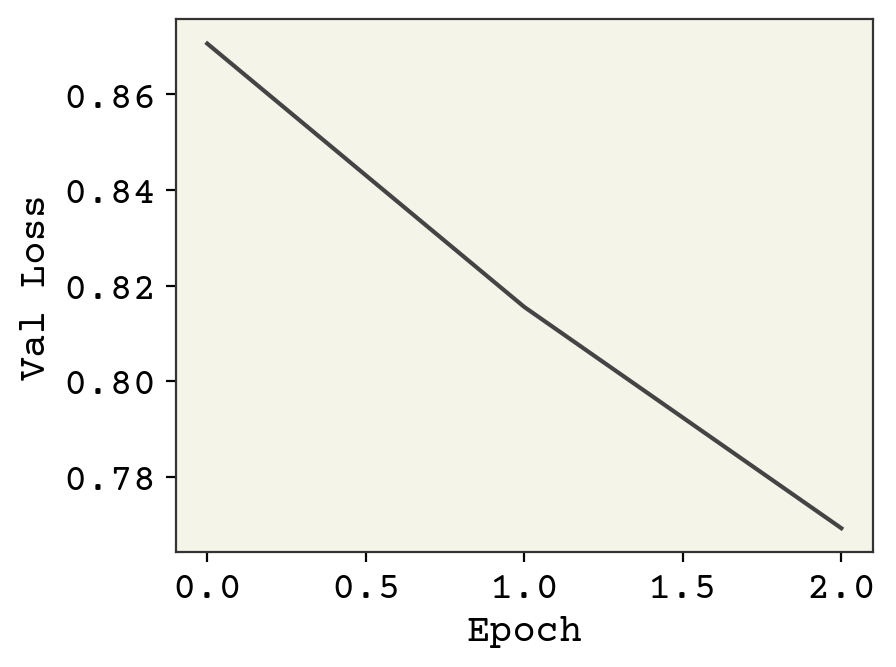

In [19]:
epochs = 3
eta = 1e-3
baseline_val_loss = [0.0 for _ in range(epochs)]
for epoch in range(epochs):
    for d in train_set:
        (e, x), y_raw = convert_record(d)
        y = transform_label(y_raw)
        grad_est = baseline_loss_grad(e, y, w, b)
        # update regression weights
        w -= eta * grad_est[0]
        b -= eta * grad_est[1]
    # compute validation loss
    for v in valid_set:
        (e, x), y_raw = convert_record(v)
        y = transform_label(y_raw)
        # convert SE to RMSE
        baseline_val_loss[epoch] += baseline_loss(e, y, w, b)
    baseline_val_loss[epoch] = jnp.sqrt(baseline_val_loss[epoch] / 1000)
    eta *= 0.9
plt.plot(baseline_val_loss)
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.show()


This is poor performance, but it gives us a baseline value of what we can expect. One unusual detail I did in this training was to slowly reduce the learning rate. This is because our features and labels are all in different magnitudes. Our weights need to move far to get into the right order of magnitude and then need to fine-tune a little. Thus, we start at high learning rate and decrease.

In [ ]:
ys = []
yhats = []
for v in valid_set:
    (e, x), y = convert_record(v)
    ys.append(y)
    yhat_raw = baseline_model(e, w, b)
    yhat = transform_prediction(yhat_raw)
    yhats.append(yhat)


plt.plot(ys, ys, "-")
plt.plot(ys, yhats, ".")
plt.xlabel("Energy")
plt.ylabel("Predicted Energy")
plt.show()


You can see that the broad trends about molecule size capture a lot of variance, but more work needs to be done. 

## Example GNN Model

We now can work with this data to build a model. Let's build a simple model that can model energy and obeys the invariances required of the problem. We will use a graph neural network (GNN) because it obeys permutation invariance. We will create a *graph* from the coordinates/element vector by joining all atoms to all other atoms and using their inverse pairwise distance as the edge weight. The choice of pairwise distance gives us translation and rotation invariance. The choice of inverse distance means that atoms which are far away naturally have low edge weights.

I will now define our model using the Battaglia equations {cite}`battaglia2018relational`. As opposed to most examples we've seen in class, I will use the graph level feature vector $\vec{u}$ which will ultimately be our estimate of energy. The edge update will only consider the sender and the edge weight with trainable parameters:

\begin{equation}
      \vec{e}^{'}_k = \phi^e\left( \vec{e}_k, \vec{v}_{rk}, \vec{v}_{sk}, \vec{u}\right) = \sigma\left(\vec{v}_{sk}\vec{w}_ee_k + \vec{b}_e\right)
\end{equation}

where the input edge $e_k$ will be a single number (inverse pairwise distance) and $\vec{b}_e$ is a trainable bias vector. We will use a sum aggregation for edges (not shown). $\sigma$ is a leaky ReLU. The leaky just prevents vanishing gradients, which I found empirically to reduce performance here. The node update will be 

\begin{equation}
   \vec{v}^{'}_i = \phi^v\left( \bar{e}^{'}_i, \vec{v}_i, \vec{u}\right) = \sigma\left(\mathbf{W}_v \bar{e}^{'}_i\right) + \vec{v}_i
\end{equation}

The global node aggregation will also be a sum. Finally, we have our graph feature vector update:

\begin{equation}
    \vec{u}^{'} = \phi^u\left( \bar{e}^{'},\bar{v}^{'}, \vec{u}\right) = \sigma\left(\mathbf{W}_u\bar{v}^{'}\right) + \vec{u}
\end{equation}


To compute the final energy, we'll use our regression equation:

\begin{equation}
    \hat{E} = \vec{w}\cdot \vec{u} + b
\end{equation}

One final detail is that we will pass on $\vec{u}$ and the nodes, but we will keep the edges the same at each GNN layer. Remember this is an example model: there are many changes that could be made to the above. Also, it is not kernel learning which is the favorite for this domain. Let's implement it though and see if it works. 

### JAX Model Implementation

In [ ]:
def x2e(x):
    """convert xyz coordinates to inverse pairwise distance"""
    r2 = jnp.sum((x - x[:, jnp.newaxis, :]) ** 2, axis=-1)
    e = jnp.where(r2 != 0, 1 / r2, 0.0)
    return e


def gnn_layer(nodes, edges, features, we, web, wv, wu):
    """Implementation of the GNN"""
    # make nodes be N x N so we can just multiply directly
    # ek is now shaped N x N x features
    ek = jax.nn.leaky_relu(
        web
        + jnp.repeat(nodes[jnp.newaxis, ...], nodes.shape[0], axis=0)
        @ we
        * edges[..., jnp.newaxis]
    )
    # sum over neighbors to get N x features
    ebar = jnp.sum(ek, axis=1)
    # dense layer for new nodes to get N x features
    new_nodes = jax.nn.leaky_relu(ebar @ wv) + nodes
    # sum over nodes to get shape features
    global_node_features = jnp.sum(new_nodes, axis=0)
    # dense layer for new features
    new_features = jax.nn.leaky_relu(global_node_features @ wu) + features
    # just return features for ease of use
    return new_nodes, edges, new_features


We have implemented the code to convert coordinates into inverse pairwise distance and the GNN equations above. Let's test them out.

In [ ]:
graph_feature_len = 8
node_feature_len = 16
msg_feature_len = 16


# make our weights
def init_weights(g, n, m):
    we = np.random.normal(size=(n, m), scale=1e-1)
    wb = np.random.normal(size=(m), scale=1e-1)
    wv = np.random.normal(size=(m, n), scale=1e-1)
    wu = np.random.normal(size=(n, g), scale=1e-1)
    return [we, wb, wv, wu]


# make a graph
nodes = e
edges = x2e(x)
features = jnp.zeros(graph_feature_len)

# eval
out = gnn_layer(
    nodes,
    edges,
    features,
    *init_weights(graph_feature_len, node_feature_len, msg_feature_len),
)
print("input feautres", features)
print("output features", out[2])


Great! Our model can update the graph features. Now we need to convert this into callable and loss. We'll stack two GNN layers.

In [ ]:
# get weights for both layers
w1 = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
w2 = init_weights(graph_feature_len, node_feature_len, msg_feature_len)
w3 = np.random.normal(size=(graph_feature_len))
b = 0.0


@jax.jit
def model(nodes, coords, w1, w2, w3, b):
    f0 = jnp.zeros(graph_feature_len)
    e0 = x2e(coords)
    n0 = nodes
    n1, e1, f1 = gnn_layer(n0, e0, f0, *w1)
    n2, e2, f2 = gnn_layer(n1, e1, f1, *w2)
    yhat = f2 @ w3 + b
    return yhat


def loss(nodes, coords, y, w1, w2, w3, b):
    return (model(nodes, coords, w1, w2, w3, b) - y) ** 2


loss_grad = jax.grad(loss, (3, 4, 5, 6))


```{margin}
You could pad the molecules to all be the same shape. This is a common strategy. We will skip this though for simplicity. 
```

One small change we've made below is that we scale the learning rate for the GNN to be $ 1 / 10$ of the rate for the regression parameters. This is because the GNN parameters need to vary slower based on trial and error. 

In [ ]:
eta = 1e-3
val_loss = [0.0 for _ in range(epochs)]
for epoch in range(epochs):
    for d in train_set:
        (e, x), y_raw = convert_record(d)
        y = transform_label(y_raw)
        grad = loss_grad(e, x, y, w1, w2, w3, b)
        # update regression weights
        w3 -= eta * grad[2]
        b -= eta * grad[3]
        # update GNN weights
        for i, w in [(0, w1), (1, w2)]:
            for j in range(len(w)):
                w[j] -= eta * grad[i][j] / 10
    # compute validation loss
    for v in valid_set:
        (e, x), y_raw = convert_record(v)
        y = transform_label(y_raw)
        # convert SE to RMSE
        val_loss[epoch] += loss(e, x, y, w1, w2, w3, b)
    val_loss[epoch] = jnp.sqrt(val_loss[epoch] / 1000)
    eta *= 0.9
plt.plot(baseline_val_loss, label="baseline")
plt.plot(val_loss, label="GNN")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Val Loss")
plt.show()


This is a large dataset and we're under training, but hopefully you get the principles of this process! Finally, we'll examine our parity plot. 

In [ ]:
ys = []
yhats = []
for v in valid_set:
    (e, x), y = convert_record(v)
    ys.append(y)
    yhat_raw = model(e, x, w1, w2, w3, b)
    yhats.append(transform_prediction(yhat_raw))


plt.plot(ys, ys, "-")
plt.plot(ys, yhats, ".")
plt.xlabel("Energy")
plt.ylabel("Predicted Energy")
plt.show()


The clusters are molecule types/sizes. You can see we're starting to get the correct trend within the clusters, but a lot of work needs to be done to move some of them. Additional learning required!

## Relevant Videos About Modeling QM9

<iframe width="560" height="315" src="https://www.youtube-nocookie.com/embed/S09kzo5piAM" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>


## Cited References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```